In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
import aesara.tensor as at

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
n = 20

mu1 = np.ones(n) * (1. / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
logdsigma = np.linalg.slogdet(sigma)[1]

w1 = 0.1
w2 = (1 - w1)

In [4]:
def two_gaussians(x):
    log_like1 = - 0.5 * n * at.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    log_like2 = - 0.5 * n * at.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    return pm.math.logsumexp([at.log(w1) + log_like1, at.log(w2) + log_like2])

In [5]:
with pm.Model() as model:
    X = pm.Uniform('X',
                   shape=n,
                   lower=-2. * np.ones_like(mu1),
                   upper=2. * np.ones_like(mu1),
                   testval=-1. * np.ones_like(mu1))
    llk = pm.Potential('llk', two_gaussians(X))
    
    idata_smc = pm.sample_smc(5000)

/u/32/martino5/unix/proyectos/00_BM/pymc3/pymc/distributions/continuous.py:167: FutureWarning: The `testval` argument is deprecated; use `initval`.
  return super().__new__(cls, *args, **kwargs)
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/u/32/martino5/unix/proyectos/00_BM/pymc3/pymc/smc/smc.py:179: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  return sample_prior_predictive(
/u/32/martino5/unix/proyectos/00_BM/pymc3/pymc/smc/smc.py:179: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  return sample_prior_predictive(
/u/32/martino5/unix/proyectos/00_BM/pymc3/pymc/smc/smc.py:179: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  return sample_prior_predictive(
/u/32/martino5/unix/proyectos/00_BM/pymc3/pymc/smc/smc.py:179: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biase

0.09005

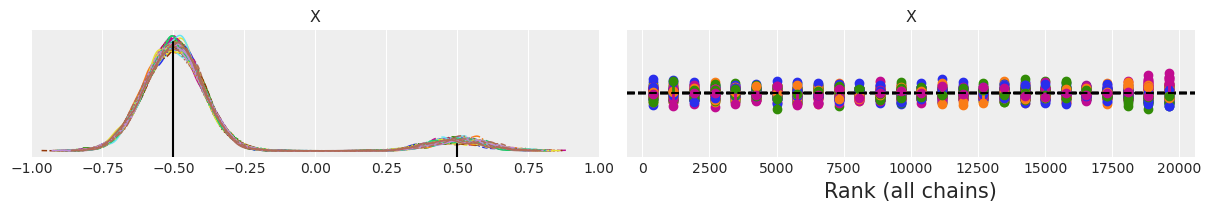

In [6]:
ax = az.plot_trace(idata_smc, compact=True, kind="rank_vlines")
ax[0, 0].axvline(-0.5, 0, .9, color="k")
ax[0, 0].axvline(0.5, 0, 0.1, color="k")
ax[0, 0].set_xlim(-1, 1)
np.mean(idata_smc.posterior["X"] > 0).item()

# Compute error score

In [7]:
# Wang bimodality index True Value
BI = abs(mu1 - mu2) * (w1*(1-w1))**0.5
posterior = idata_smc.posterior
error_score_list = []

for chain in posterior["chain"]:
    for dimension in posterior["X_dim_0"]:
        v = np.ravel(posterior.isel(chain=chain, X_dim_0=dimension)["X"])
        above_zero = v > 0
        below_zero = v < 0
        w1_ = np.mean(below_zero)
        if np.any(above_zero) and np.any(below_zero):
            BI_ = abs(v[below_zero].mean() - v[above_zero].mean()) * (w1_*(1-w1_))**0.5
        else:
            BI_ = 0
        error_score = (np.mean(((v-mu1[0]) * w1 + (v-mu2[0]) * w2))**2)**0.5 + abs(BI - BI_)
        error_score_list.append(error_score)

np.mean(error_score_list), np.std(error_score_list)

(0.02531184514102323, 0.015225069837450323)

# Hierarchical Model

For this model we may use NUTS as a "gold-standard"

In [8]:
data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)
n_counties = len(data.county.unique())

In [9]:
with pm.Model() as hierarchical_model_non_centered:
    mu_a = pm.Normal('mu_a', mu=0., sd=5)
    sigma_a = pm.HalfNormal('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=5)
    sigma_b = pm.HalfNormal('sigma_b', 5)
     
    a_offset = pm.Normal('a_offset', mu=0, sd=2, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    b_offset = pm.Normal('b_offset', mu=0, sd=2, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
 
    eps = pm.HalfNormal('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)
    idata_nuts = pm.sample(2000)
    idata_smc = pm.sample_smc(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a_offset, b_offset, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


The number of effective samples is smaller than 10% for some parameters.


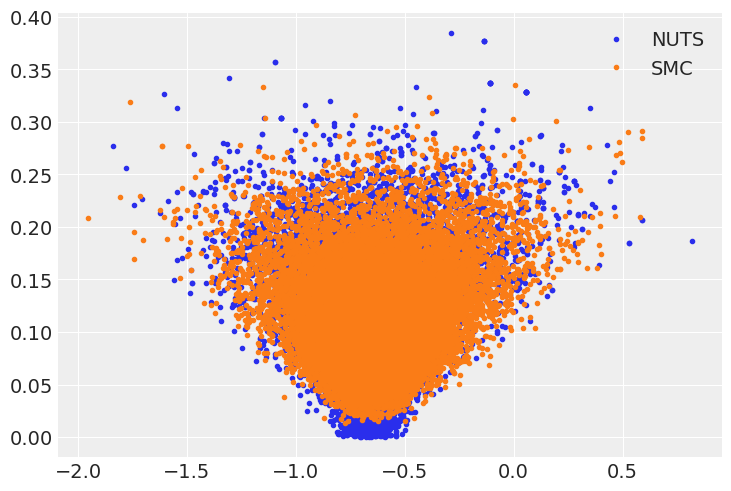

In [10]:
nuts_posterior = idata_nuts.posterior.stack(samples=("chain", "draw"))
smc_posterior = idata_smc.posterior.stack(samples=("chain", "draw"))
plt.plot(nuts_posterior["b"].isel(b_dim_0=75), nuts_posterior["sigma_b"], '.C0', label="NUTS")
plt.plot(smc_posterior["b"].isel(b_dim_0=75), smc_posterior["sigma_b"], '.C1', label="SMC")

plt.legend();